<a href="https://colab.research.google.com/github/claudia-viaro/optimal_stopping-switching/blob/main/optimal_stopping/optimal_stopping_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Formulation
Let $(\Omega, \mathcal{F}, \mathbb{P})$ be a fixed probability space on which an adapted stochastic process is defined $X=(X_t)_{0 \leq t \leq T}$ whose natural filtration is $(\mathcal{F}_t^0 := \sigma \{ X_s, s \leq t \})_{0 \leq t \leq T}$. Let $\mathbf{F}=(\mathcal{F}_0)_{0 \leq t \leq t}$ be the complete filtration of $(\mathcal{F}_t^0 := \sigma \{ X_s, s \leq t \})_{0 \leq t \leq T}$. with $P$-null sets of $\mathcal{F}$.

The stochastic process $X$ is $\mathbb{R}^d$-valued and represents the market price of $d$ financial assets (Bermudan call options) that influence the production of power. Assume $(X^i)_{i=1}^d$ follows a geometric Brownian motion satisfying the SDE:
\begin{equation}
dX_t^i = (b-\delta_i)dt + \sigma_i dW_t^i
\end{equation}
where $W$ is a standard Brownian otion on a filtered probability space $(\Omega, \mathcal{F}, (\mathcal{F}_t)_{t \geq 0}, \mathbb{P})$ and $b$, $d_i$, $\sigma_i >0$ are the drift. dividend yield and volatility of the system at time $t$.

We will consider a discrete time approximization (Euler schema) on an equidistant time grid $0=t_0 < t_1 < \ldots < t_N = T$, where $t_n = n \cdot T/N$. For $i = 1, \ldots, d$ we simulate $p$ paths
\begin{equation}
x^p_{n,i} = x_{0,i} \cdot \exp \Big\{ \sum_{k=0}^n \big( (b-\delta_i - \sigma^2_i /2)\Delta t + \sigma_{i} \sqrt{\Delta t} \cdot Z_{k, i}^p \big)     \Big\}
\end{equation}
where $\Delta t = T/N$ and $Z_{k, i}^{p} \sim \mathcal{N} (0,1)$.



In [1]:
import numpy as np
import torch
import torch.nn as nn
np.random.seed(234198)
import itertools
import random
import time
import scipy.stats
import math
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.utils.data as tdata
from google.colab import files
import helper

In [2]:
class BlackScholes:
  def __init__(self, drift, sigma, delta, spot, assets,  paths, periods,
         maturity, strike, dividend=0):

    self.drift = drift - dividend
    self.sigma = sigma
    self.delta = delta
    self.spot = spot
    self.assets = assets
    self.paths = paths
    self.periods = periods
    self.maturity = maturity
    self.strike = strike
    self.dt = self.maturity / self.periods
    self.df = math.exp(-self.drift * self.dt)

  def drift_fct(self, x, t):
    del t
    return self.drift * x

  def diffusion_fct(self, x, t, v=0):
    del t
    return self.sigma * x



  def simulate_process(self):
    """Returns a nparray (nb_paths * assets * nb_dates) with prices."""
    paths = self.paths
    spot_paths = np.empty((self.periods+1, paths, self.assets ))

    spot_paths[0, :, :] = self.spot
    random_numbers = np.random.normal(
        0, 1, (self.periods, paths, self.assets ))
    dW = random_numbers * np.sqrt(self.dt)
    drift = self.drift
    r = np.repeat(np.repeat(np.repeat(
        np.reshape(drift, (-1, 1, 1)), self.periods, axis=0),
        paths, axis=1), self.assets, axis=2)
    sig = np.ones((self.periods, paths, self.assets))*self.sigma
    #sig = np.repeat(np.repeat(np.repeat(
    #    np.reshape(self.sigma, (-1, 1, 1)), self.periods+1, axis=2),
    #    paths, axis=1), self.assets, axis=0)
    
    spot_paths[1:, :,  :] = np.repeat(
        spot_paths[0:1, :, :], self.periods, axis=0)* np.exp(np.cumsum((r-self.delta) * self.dt - (sig ** 2) * self.dt / 2 + sig * dW, axis=0))

    return spot_paths #.reshape(spot_paths.shape[2], spot_paths.shape[0], spot_paths.shape[1])



class GBM:
    def __init__(self, drift, sigma, delta, spot, assets,  paths, periods,
         maturity, strike = 100,dividend=0):
        self.maturity = maturity
        self.strike = strike
        self.assets = assets
        self.sigma=sigma *np.ones(self.assets)
        self.delta=delta
        self.spot = spot*np.ones(self.assets)
        self.drift = drift - dividend
        self.paths = paths
        self.periods = periods
        self.dt = self.maturity / self.periods
    
    def simulate_process(self):
        
        dt = self.maturity / self.periods
        So_vec=self.spot*np.ones((1,S.paths, S.assets))
        
        Z=np.random.standard_normal((self.periods,self.paths, self.assets))
        s=self.spot*np.exp(np.cumsum((self.drift-self.delta-0.5*self.sigma**2)*dt+self.sigma*np.sqrt(dt)*Z, axis=0))
        
        s=np.append(So_vec, s, axis=0)
        return s  
    

In [3]:
'''
Neural network
'''

class Ftheta_NN(nn.Module):
  def __init__(self, assets):
    super(Ftheta_NN, self).__init__()
    H = assets + 40
    self.bn0 = nn.BatchNorm1d(num_features=assets)
    self.a1 = nn.Linear(assets, H)
    self.relu = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(num_features=H)
    self.a2 = nn.Linear(H, H)
    self.bn2 = nn.BatchNorm1d(num_features=H)
    self.a3 = nn.Linear(H, 1)
    self.bn3 = nn.BatchNorm1d(num_features=1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input):
    out = self.bn0(input)
    out = self.a1(out)

    out = self.relu(out)
    #out = self.bn1(out)

    #out = self.a2(out)
    
    #out = self.relu(out)
    out = self.bn2(out)
    out = self.a3(out)
    
    out = self.sigmoid(out)
    return out



# set initial weights of a linear layer of the NN with uniform values and bias=0.01 (or choose zero initial weights)
def init_weights(m):
  if isinstance(m, torch.nn.Linear):
    torch.manual_seed(42)
    # torch.nn.init.zeros_(m.weight)
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)
    
 

In [4]:
'''
PAYOFF
'''

# Payoff
class Payoff:
  def __init__(self, model):
    self.strike = model.strike

  def MaxCall(self, X):
    payoff = np.max(X, axis=1) - self.strike
    return payoff.clip(0, None)

  def MaxPut(self, X):
    payoff = self.strike - np.max(X, axis=1)
    return payoff.clip(0, None)   


  def GeometricPut(self, X):
    dim = len(X[1])  
    payoff = self.strike - np.prod(X, axis=1) ** (1/dim)
    return payoff.clip(0, None)


# Class "Recursive"
This class contains the main calculations of the algorithm, hence the recursion.

### price
First we start with some elements:
1. we simulate $d$ asset prices $\{X^i \}^d_{i=1}$ along $m$ paths according to a geometric Brownian motion process. We consider the iys discretized version on an equidistant time grid, $t_n = n \cdot T/N$ for $n=0, \ldots, N$:
\begin{equation} \tag{7}
x_{n,i}^m = x_{0,i} \cdot \exp \Big\{\sum_{k=0}^n \Big((r-\delta_i - \sigma_i^2 /2) \Delta t + \sigma_i \sqrt{\Delta t} \cdot Z_{k, i}^m  \Big) \Big\}
\end{equation}
where $(r-\delta_i) \in \mathbb{R}$ and $\sigma_i >0$ are the drift and volatility of the system $X$, $\Delta t =T/N$ and $Z_{k, i}^m \sim \mathcal{N}(0,1)$
2. we define the discount factor $\exp \{(r-\delta_i )\Delta t \}$


Then we can start the recursion:

*At maturity $N$*
1. we compute the profit at $N$ "final_payoff" $(4)$

*Before maturity, for each date $ n=N-1, \ldots, 0$*
1. we compute "current_payoff" using "Profit_training.running()"
2. we obtain a stopping rule for each path, using as arguments the current payoff, the discounted final payoff (now called "values") and the entire process. Record then the stopping rules in "F_theta_train" **[I am not sure about the discounting]**
3. we compute $\check{V}_{n}^i$ according to $(4)$, using "Payoff.Maxcall()"  and record it under "Y_train". Hence we have a matrix with dimension periods x paths, recording $\check{V}_{n}^i$
5. we compute the mean estimate across paths for each date (Y_test_mean) and the standard error so that we can plot the values with a 95% CI

In [5]:
def draw_stock_model(stockmodel):
    stock_paths = stockmodel

    # draw a path
    one_path = stock_paths[:, 0, 0]
    dates = np.array([i for i in range(len(one_path))])
    plt.plot(dates, one_path, label='stock path')
    plt.ylabel('Stock price')
    plt.ylabel('Time')
    plt.legend()
    return plt.show()   

In [6]:
class Training_network(object):

  def __init__(self, assets,  epochs=400, batch_size=2000):
    self.assets = assets
    self.epochs = epochs
    self.batch_size = batch_size
    self.network = Ftheta_NN(self.assets).double()
    self.network.apply(init_weights)

  # training part
  def train_network(self,  stock_values, current_payoff,
                    future_payoff):
        
    # several optimization methods are available (here Adam algorithm). as argument input the parameters to be optimized    
    optimizer = optim.Adam(self.network.parameters())
    
    # set values for the NN inputs (stock_values) and loss function
    future_payoff = torch.from_numpy(future_payoff).double()
    current_payoff = torch.from_numpy(current_payoff).double()
    X_inputs = torch.from_numpy(stock_values).double() # input to the NN must be a tensor
    self.network.train(True) # set training mode ON
    ones = torch.ones(len(future_payoff)) # we need a vector of 1's in the loss function
    losses = []
    for epoch in range(self.epochs):
      running_loss = 0.0

      for batch in tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=self.batch_size, drop_last=False):
        
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
          F_theta = self.network.forward((X_inputs[batch])).reshape(-1) 
          reward = (current_payoff[batch].reshape(-1)* F_theta + 
                    future_payoff[batch] * (ones[batch] - F_theta)) 
          
          # compute loss function
          loss = -torch.mean(reward)
          
          # compute gradients
          loss.backward()
          # take a step, updating the parameters 
          optimizer.step()

          running_loss += loss.item() * self.batch_size
      epoch_loss = running_loss /  len(tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=self.batch_size, drop_last=False).sampler)
      losses.append(epoch_loss)          
    
    torch.save(self.network.state_dict(), 'checkpoint.pth')

    return F_theta, self.network, losses  
  
  # function to inform the NN to perform a testing phase
  def evaluate_network(self, X_inputs):
    state_dict = torch.load('checkpoint.pth')
    self.network.load_state_dict(state_dict)

    self.network.eval()
    X_inputs = torch.from_numpy(X_inputs).double()
    
    # the output is a probability for each date and path
    # it is obtained by feeding the NN with the dimension of the assets (at a specific date for all paths), 
    outputs = self.network(X_inputs)
    return outputs.view(X_inputs.size()).detach().numpy()


#Training

We conduct $3000+d$ training steps and for each we generate a batch of $8192$ paths of $(X_n)_{n=0}^N$.

The resulting output will be the stopping decisions $f^{\theta_n}$


In [7]:
# simulate paths Y
hyperparam_training = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':20, 'periods': 9, 'maturity': 1., 'strike' : 100,'assets':2,  'spot':90,}
S_train=BlackScholes(**hyperparam_training)


In [8]:
class Training:
  def __init__(self, model, payoff_function):

    self.model = model
    self.payoff = payoff_function(self.model)
    self.neural_stopping = Training_network(self.model.assets)

  def value(self):
    model = self.model
    stock_paths = self.model.simulate_process()    
    mods=[None]*model.periods # record the models of the NN for testing
    loss_functions = [None]*model.periods
    
    
    # AT MATURITY N
    final_payoff = self.payoff.MaxCall(stock_paths[-1, :, :]) # payoff of the last date
    print("date", model.periods, ",", model.paths)
 

    # from n=N-1 to 0 with steps of -1

    for date in range(stock_paths.shape[0] - 2, 0, -1):      
      current_payoff = self.payoff.MaxCall(stock_paths[date, :, :])
      stopping_rule , networks, loss = self.neural_stopping.train_network(stock_paths[date, : , :], 
                                                  current_payoff,
                                                  final_payoff*(np.math.exp((-model.drift) * (model.periods-date)/model.periods)))
      mods[date]=networks
      loss_functions[date]=loss
      print("date", date, ",", len([1 for l in stopping_rule if l > 0.5]), " mean loss ", np.mean(loss))


    return mods, loss_functions

  def stop(self, stock_values, current_payoff, future_payoff, train=True):
    if train:
      stopping_probability, networks, losses = self.neural_stopping.train_network(stock_values,
                                                                          current_payoff,
                                                                          future_payoff)
      #inputs = stock_values
      #stopping_probability , networks   = self.neural_stopping.evaluate_network(inputs)
    return stopping_probability, networks, losses  

In [9]:
pricing = Training(S_train, Payoff)
mods, loss_function = pricing.value()

date 9 , 20
date 8 , 5  mean loss  -331.46735663428376
date 7 , 2  mean loss  -329.26859268781226
date 6 , 1  mean loss  -323.6880400167691
date 5 , 2  mean loss  -316.8774580118984
date 4 , 0  mean loss  -311.1428225124987
date 3 , 0  mean loss  -304.5723559810087
date 2 , 0  mean loss  -297.8787755140147
date 1 , 0  mean loss  -291.33225397192473


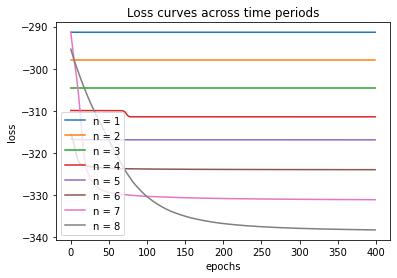

In [10]:
filtered_list = list(filter(None, loss_function))
legend = ["n = 1", "n = 2", "n = 3", "n = 4", "n = 5", "n = 6", "n = 7", "n = 8"]

for i in range(len(filtered_list)):
  epochs = np.array([i for i in range(len(filtered_list[0]))])
  plt.plot(epochs, filtered_list[i], label='loss funciton')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(legend)
  plt.title('Loss curves across time periods')
  plt.plot()


In [11]:
'''

# CHECK TRAINING

# check training
hyperparam_training = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':7, 'periods': 9, 'maturity': 3., 'strike' : 100,'assets':2,  'spot':90,}
model=BlackScholes(**hyperparam_training)
payoff = Payoff(model)
stock_paths = model.simulate_process()    
disc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))
mods=[None]*model.periods
    
    
# AT MATURITY N
immediate_exercise_value = payoff.MaxCall(stock_paths[-1, :, :]) # payoff of the last date
final = immediate_exercise_value


# recursive calc. before maturity
date = stock_paths.shape[0] - 3
print("date", date)
immediate_exercise_value =  payoff.MaxCall(stock_paths[date, :, :])
immediate_exercise_value = torch.from_numpy(immediate_exercise_value).double()
discounted_next_values = disc_factor * (torch.from_numpy(final).double())
X_inputs = torch.from_numpy(stock_paths[date, : , :]).double() # input to the NN must be a tensor

print(X_inputs.shape) # 7 paths, 2 assets for that date
print("X_inputs", X_inputs)



for batch in tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=4, drop_last=False):
  print("batch", X_inputs[batch])
'''


'\n\n# CHECK TRAINING\n\n# check training\nhyperparam_training = {\'drift\': 0.2, \'sigma\': 0.05, \'delta\': 0.1,  \'paths\':7, \'periods\': 9, \'maturity\': 3., \'strike\' : 100,\'assets\':2,  \'spot\':90,}\nmodel=BlackScholes(**hyperparam_training)\npayoff = Payoff(model)\nstock_paths = model.simulate_process()    \ndisc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))\nmods=[None]*model.periods\n    \n    \n# AT MATURITY N\nimmediate_exercise_value = payoff.MaxCall(stock_paths[-1, :, :]) # payoff of the last date\nfinal = immediate_exercise_value\n\n\n# recursive calc. before maturity\ndate = stock_paths.shape[0] - 3\nprint("date", date)\nimmediate_exercise_value =  payoff.MaxCall(stock_paths[date, :, :])\nimmediate_exercise_value = torch.from_numpy(immediate_exercise_value).double()\ndiscounted_next_values = disc_factor * (torch.from_numpy(final).double())\nX_inputs = torch.from_numpy(stock_paths[date, : , :]).double() # input to the NN must be a tensor\n\npri

#Lower bound

the stopping time $\tau^{\Theta}$ gives a lower bound $L=\mathbb{E}g(\tau^{\Theta}, X_{\tau^{\Theta}})$ for the optimal value $V_0= \sup_{\tau \in \mathcal{T}}\mathbb{E}g(\tau, X_{\tau})$.

Simulate 
- $K_L = 1024$ paths $(y_n^k)_{n=0}^N$, $k=1, \ldots, K_L$, of $(X_n)_{n=0}^N$ and assume these are drawn independently from the realizations $(x_n^k)_{n=0}^N$, $k=1, \ldots, K$.

The unbiased estimate of the lower bound $L$ is given by
\begin{equation}
\hat{L}=\frac{1}{K_L} \sum_{k=1}^{K_L} g(l^k, y_{l^k}^k)
\end{equation}
where $l^k = l(y_0^k, \ldots, y_{N-1}^k)$

In [27]:
# Testing phase - Lower bound

# sample y from the process (Y)
hyperparam_testing_L = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':40, 'periods': 9, 'maturity': 1., 'strike' : 100,'assets':2,  'spot':90,}
S_test_L=BlackScholes(**hyperparam_testing_L)

# now we can compute all the stopping times recursively

In [13]:
'''

model = S_test_L
stock_paths = model.simulate_process()
date = stock_paths.shape[0] - 2

mod_curr = mods[date]     
probs=mod_curr(torch.from_numpy(stock_paths[date])) 
np_probs=probs.detach().numpy().reshape(model.paths)     
which = np_probs > 0.5
print(which)

neural_stopping = Training_network(model.assets, model.paths)
stopping_probability , networks   = neural_stopping.evaluate_network(stock_paths[date])
print(stopping_probability  > 0.5)
'''

'\n\nmodel = S_test_L\nstock_paths = model.simulate_process()\ndate = stock_paths.shape[0] - 2\n\nmod_curr = mods[date]     \nprobs=mod_curr(torch.from_numpy(stock_paths[date])) \nnp_probs=probs.detach().numpy().reshape(model.paths)     \nwhich = np_probs > 0.5\nprint(which)\n\nneural_stopping = Training_network(model.assets, model.paths)\nstopping_probability , networks   = neural_stopping.evaluate_network(stock_paths[date])\nprint(stopping_probability  > 0.5)\n'

In [35]:
# Testing

class Testing_Lower:
  def __init__(self, model, payoff, mods):   
    self.model = model # argument is S   
    self.payoff = payoff(self.model)
    #self.neural_stopping = Training_network(self.model.assets)
    self.mods = mods



  def price(self):
    model = self.model    
    stock_paths = self.model.simulate_process()
    
 
    # at maturity N
    final_payoff = self.payoff.MaxCall(stock_paths[-1, :, :]) # payoff of the last date
    payoff_0 = self.payoff.MaxCall(stock_paths[0, :, :])  
    values = final_payoff
    print("date", model.periods, ":", 1.0," , ", 1.0, " , ", model.paths, "value", round(np.mean(values), 3))


    # recursive calc. before maturity
         
    for date in range(stock_paths.shape[0] - 2, 0, -1):
      current_payoff = self.payoff.MaxCall(stock_paths[date, :, :])
      mod_curr=self.mods[date]

      #probs = self.neural_stopping.evaluate_network(stock_paths[date, : , :])
      
      probs=mod_curr(torch.from_numpy(stock_paths[date, :, :])) 
      np_probs=probs.detach().numpy().reshape(self.model.paths)     
      which = np_probs > 0.5

      values[which] = current_payoff[which]
      values[~which] *= (np.math.exp((-model.drift) * (model.periods-date)/model.periods))
      print("date", date, ":", round(np.min(np_probs), 3)," , ", round(np.max(np_probs), 3), " , ", len([1 for l in np_probs if l > 0.5]), "value", round(np.mean(values), 3))

    
    return round(payoff_0[0], 3), round(np.mean(values)*(np.math.exp((-model.drift) * (date/model.periods))) , 3)



In [36]:
price_testing = Testing_Lower(S_test_L, Payoff, mods)

Y_test_mean, MC_estimate = price_testing.price()
print(Y_test_mean, MC_estimate)

date 9 : 1.0  ,  1.0  ,  40 value 2.964
date 8 : 0.0  ,  0.0  ,  0 value 2.899
date 7 : 0.0  ,  0.0  ,  0 value 2.773
date 6 : 0.0  ,  0.0  ,  0 value 2.594
date 5 : 0.0  ,  0.0  ,  0 value 2.373
date 4 : 0.0  ,  0.0  ,  0 value 2.124
date 3 : 0.0  ,  0.0  ,  0 value 1.859
date 2 : 0.0  ,  0.0  ,  0 value 1.591
date 1 : 0.0  ,  0.0  ,  0 value 1.332
0.0 1.302


# Upper Bound

For every $(\mathcal{F}_n)$-martingale $(M_n)_{n=0}^N$ starting from $0$ and each sequence of integrable error terms $(\epsilon_n)_{m=0}^N$ satisfying $\mathbb{E}[\epsilon_n | \mathcal{F}_n]=0$ for all $n$, the following expression provides an upper bound for $V_0$, which is also tight if $M=M^H$ and $\epsilon \equiv 0$.
\begin{equation}
U = \mathbb{E} \Big[ \max_{0 \leq n \leq N} [g(n, X_n) - M_n^{\Theta} - \epsilon_n ]  \Big]
\end{equation}


We need an expression for $M^H$ and use the Doob-Meyer decomposition on the Snell envelope of the reward process:
\begin{equation}
H_n = \text{ess} \sup_{\tau \in \mathcal{T}_n} \mathbb{E}[g(\tau)| \mathcal{F}_n], \;\;\;\ n=0, 1, \ldots, N
\end{equation}
where its Doob-Meyer deomposition is given by:
\begin{equation}
H_n = H_0 + M_n^H - A_n^H
\end{equation}
and
\begin{equation}
M_0^H = 0\;\;\;\; \text{and} \;\; M_n^H-M_{n-1}^H=H_n-\mathbb{E}[H_n | \mathcal{F}_{n-1}], \;\;\; n=1, \ldots, N
\end{equation}



We use $\tau^{\Theta}$ to construct a martingale close to $M^H$. The martingale part of $(H_n^{\Theta})_{n=0}^N$ is given by:
\begin{equation}
\begin{split}
&M_0^{\Theta}\\
&M_N^{\Theta}- M_{n-1}^{\Theta} = H_n^{\Theta}-\mathbb{E}[H_n^{\Theta} | \mathcal{F}_{n-1}] = f^{\theta_n}(X_n)g(n, X_n) + (1- f^{\theta_n})) C_n^{\Theta}-C_{n-1}^{\Theta}, \;\; n \geq 1
\end{split}
\end{equation}
and the continuation value is:
\begin{equation}
C_n^{\Theta}=\mathbb{E}[g(\tau_{n+1}^{\Theta}, X_{\tau_{n+1}^{\Theta}})| \mathcal{F}_n] = \mathbb{E}[g(\tau_{n+1}^{\Theta}, X_{\tau_{n+1}^{\Theta}})| X_n], \;\;\;\ n=0, 1, \ldots, N-1
\end{equation}
there is no need to specify $C_N^{\Theta}$ because $(1- f^{\theta_N}(X_N))$ is always $0$.


Simulate 
- $K_U = 1024$ paths $(z_n^k)_{n=0}^N$, $k=1, \ldots, K_U$, of $(X_n)_{n=0}^N$
- $K_U \times J$ realizations $(v_n^{k,j})_{n=0}^N$, $k=1, \ldots, K_U$, $j=1, \ldots, J$, of $(W_{t_n} - W_{t_n - 1})_{n=1}^N$ with $J=16384$
- for all $n$ and $k$, generate the $i$-th component of the $j$-th continuation path departing from  $z_n^k$ according to:
\begin{equation}
\tilde{z}_n^{i,k,j}=z_n^{i,k} \exp \Big([r- \delta_i - \sigma_i^2 /2] (m-n)\Delta t + \sigma_i [v_{n+1}^{i,k,j} + \ldots, v_{m}^{i,k,j}]  \Big), \;\;\;\; m=n+1, \ldots, N
\end{equation}
we assume that $\tilde{z}_{n+1}^{k,j}, \ldots, \tilde{z}_{N}^{k,j}$ are conditionally independent of each other and of $z_{n+1}^{k}, \ldots, z_{N}^{k}$ 


In [ ]:
# Testing phase - Upper bound

# sample Z from the process (X)
hyperparam_testing_U = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':1024, 'periods': 4, 'maturity': 3., 'strike' : 100,'assets':1,  'spot':90,}
S_test_U=BlackScholes(**hyperparam_testing_U)
stock_paths = S_test_U.simulate_process()
print(stock_paths.shape) #(5, 1024, 1)

In [ ]:
# need to generate v values

class Zvalues:
  def __init__(self, drift, sigma, delta, spot, assets,  paths, periods,
         maturity, strike, dividend=0):

    self.drift = drift - dividend
    self.sigma = sigma
    self.delta = delta
    self.spot = spot
    self.assets = assets
    self.paths = paths
    self.periods = periods
    self.maturity = maturity
    self.strike = strike
    self.dt = self.maturity / self.periods
    self.df = math.exp(-self.drift * self.dt)

  def drift_fct(self, x, t):
    del t
    return self.drift * x

  def diffusion_fct(self, x, t, v=0):
    del t
    return self.sigma * x



  def simulate_process(self):
    """Returns a nparray (nb_paths * assets * nb_dates) with prices."""
    paths = self.paths
    spot_paths = np.empty((self.periods+1, paths))

    spot_paths[0, :] = self.spot
    random_numbers = np.random.normal(
        0, 1, (self.periods, paths))
    dW = random_numbers * np.sqrt(self.dt)
    drift = self.drift
    r = np.repeat(np.repeat(
        np.reshape(drift, (-1, 1)), self.periods, axis=0),
        paths, axis=1)
    sig = np.ones((self.periods, paths))*self.sigma
    #sig = np.repeat(np.repeat(np.repeat(
    #    np.reshape(self.sigma, (-1, 1, 1)), self.periods+1, axis=2),
    #    paths, axis=1), self.assets, axis=0)
    
    spot_paths[1:, :] = np.repeat(
        spot_paths[0:1, :], self.periods, axis=0)* np.exp(np.cumsum((r-self.delta) * self.dt - (sig ** 2) * self.dt / 2 + sig * dW, axis=0))

    return spot_paths #.reshape(spot_paths.shape[2], spot_paths.shape[0], spot_paths.shape[1])

In [ ]:
hyperparam_V = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1,  'paths':7, 'periods': 4, 'maturity': 3., 'strike' : 100,  'assets': 2,'spot':90,}
S_test_U=Zvalues(**hyperparam_V)
stock_paths_Z = S_test_U.simulate_process()
print(stock_paths_Z)

In [ ]:
W_matrix = np.random.normal(0, 1, (S_test_U.periods+1, 3, 2))
V_matrix = np.zeros((S_test_U.periods+1, 3, 2))
V_matrix[0, :, :] = W_matrix[0, :, :]

for i in range(1,S_test_U.periods+1):
  V_matrix[i, :, :] = W_matrix[i, :, :] - W_matrix[i-1, :, :]
print(V_matrix.shape) #(5, 3, 2)

print(V_matrix)

In [ ]:
# build z tilde matrix

Z_matrix = np.zeros((S_test_U.periods+1, 3, 2))
paths = S_test_U.paths
dW = V_matrix * np.sqrt(S_test_U.dt)
drift = S_test_U.drift
r = np.repeat(np.repeat(np.repeat(
        np.reshape(drift, (-1, 1, 1)), S_test_U.periods, axis=0),
        paths, axis=1), 2, axis=2)
sig = np.ones((S_test_U.periods, paths, 2))*S_test_U.sigma
print(S_test_U.periods, stock_paths_Z.shape)
a = np.repeat(stock_paths_Z[0:1, :], S_test_U.periods, axis=0)
print(a.shape)
print(stock_paths_Z[0:1, :])
Z_matrix[1:, :, :] = np.repeat(stock_paths_Z[0:1, :], S_test_U.periods, axis=0)* np.exp(np.cumsum((r-S_test_U.delta) * S_test_U.dt - (sig ** 2) * S_test_U.dt / 2 + sig * dW, axis=0))

In [ ]:
# Estimate continuation values

class continuation:
  def __init__(self, model, payoff, mods):   
    self.model = model # argument is S   
    self.payoff = payoff(self.model)
    self.mods = mods

  def price(self):
    model = self.model
    disc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))
    stock_paths = self.model.simulate_process()

    F_theta_test=np.zeros((model.periods+1,model.paths))
    F_theta_test[model.periods,:]=1
    C_test=np.zeros(self.model.periods+1)
    
 
    # at maturity N
    final_payoff = self.payoff.MaxCall(stock_paths[-1, :, :]) # payoff of the last date
    C_test[model.periods] = np.mean(final_payoff)
    payoff_0 = self.payoff.MaxCall(stock_paths[0, :, :])  
    values = final_payoff
    print("date", model.periods, ":", 1," , ", 1, " , ", model.paths)


    # recursive calc. before maturity
         
    for date in range(stock_paths.shape[0] - 2, 0, -1):
      current_payoff = self.payoff.MaxCall(stock_paths[date, :, :])
      mod_curr=self.mods[date]
      probs=mod_curr(torch.from_numpy(stock_paths[date])) 
      np_probs=probs.detach().numpy().reshape(self.model.paths)
      print("date", date, ":", round(np.min(np_probs), 3)," , ", round(np.max(np_probs), 3), " , ", len([1 for l in np_probs if l > 0.5]))

      which = np_probs > 0.5

      values[which] = current_payoff[which]
      values[~which] *= disc_factor
      C_test[date]=np.mean(values)

    
    return C_test

In [ ]:
continuation_values = continuation(S_test_U, Payoff, mods)

print(continuation_values.price())

In [ ]:
model = S
payoff = Payoff(model)
disc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))
stock_paths = model.simulate_process()

F_theta_test=np.zeros((model.periods+1,model.paths))
F_theta_test[model.periods,:]=1
C_test=np.zeros(model.periods+1)
print(C_test)


# at maturity N
final_payoff = payoff.MaxCall(stock_paths[-1, :, :]) # payoff of the last date
print(final_payoff)
C_test[model.periods] = np.mean(final_payoff)

In [ ]:
def stop(stock_values, current_payoff, future_payoff, train=True):
    if train:
      neural_stopping.train_network(
          stock_values,
          current_payoff ,
          future_payoff)
      inputs = stock_values
      stopping_probability = neural_stopping.evaluate_network(inputs)
    return stopping_probability 


pricing = Recursive(S, Payoff, epochs=500)
model = S
payoff = Payoff(model)
neural_stopping = Train_Network(model.assets, model.paths)

stock_paths = model.simulate_process()    
disc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))
    
    
    # AT MATURITY N
final_payoff = payoff.MaxCall(stock_paths[-1, :, :]) # payoff of the last date
payoff_0 = payoff.MaxCall(stock_paths[0, :, :])  
values = final_payoff
print("date", model.periods, ":", 1," , ", 1, " , ", model.paths)


# recursive calc, from n=N-1 to 0 with steps of -1

date = 3   
current_payoff = payoff.MaxCall(stock_paths[date, :, :])
stopping_rule = stop(stock_paths[date, : , :], 
                          current_payoff,
                          values*disc_factor)
print("date", date, ":", round(np.min(stopping_rule), 3)," , ", round(np.max(stopping_rule), 3), " , ", len([1 for l in stopping_rule if l > 0.5]))
which = stopping_rule > 0.5
print(values)
print(current_payoff)
print(which)
print(values[which])
values[which] = current_payoff[which]
values[~which] *= disc_factor